In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
!which ipython

/home/rio/miniconda3/envs/mypython3/bin/ipython


In [1]:
import sys
sys.executable

'/home/rio/miniconda3/envs/multibind/bin/python'

In [3]:
import numpy as np
import pandas
import multibind

In [17]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '/mnt/c/Users/ignacio.ibarra/Dropbox/annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [18]:
data = mb.bindome.datasets.SELEX.get_data()

cardiac_complexes
# filenames 22
PRJEB14744
# filenames 11
PRJEB20112
# filenames 46
PRJEB3289
# filenames 68
PRJEB9797
# filenames 184


In [22]:
# data_sel = data[data['filename'].str.contains('GATA') | data['filename'].str.contains('FOXA1')]
# read_tf = mb.bindome.datasets.SELEX.load_read_counts('GATA4', data)
# read_tf = mb.bindome.datasets.SELEX.load_read_counts(log_each=50, n_sample=100) #  stop_at=50)
# df = mb.bindome.datasets.ProBound.GR_mult_conc()
# df = df.sort_values(1, ascending=False).reset_index(drop=True)

In [23]:
import tempfile
tempdir = tempfile.mkdtemp()

In [24]:
!echo $tempdir
!mkdir kmc_tmp
!kmc

/tmp/tmp7pdr__0k
mkdir: cannot create directory ‘kmc_tmp’: File exists
K-Mer Counter (KMC) ver. 3.2.1 (2022-01-04)
Usage:
 kmc [options] <input_file_name> <output_file_name> <working_directory>
 kmc [options] <@input_file_names> <output_file_name> <working_directory>
Parameters:
  input_file_name - single file in specified (-f switch) format (gziped or not)
  @input_file_names - file name with list of input files in specified (-f switch) format (gziped or not)
Options:
  -v - verbose mode (shows all parameter settings); default: false
  -k<len> - k-mer length (k from 1 to 256; default: 25)
  -m<size> - max amount of RAM in GB (from 1 to 1024); default: 12
  -sm - use strict memory mode (memory limit from -m<n> switch will not be exceeded)
  -hc - count homopolymer compressed k-mers (approximate and experimental)
  -p<par> - signature length (5, 6, 7, 8, 9, 10, 11); default: 9
  -f<a/q/m/bam/kmc> - input in FASTA format (-fa), FASTQ format (-fq), multi FASTA (-fm) or BAM (-fbam) or KMC(

### This is a fast implementation of a k-mer counter using KMC

In [25]:
import os

def get_kmers(seqs, k, counts=None):
    kmers = {}
    for i, s in enumerate(seqs):
        for si in range(0, len(s) - k + 1):
            kmer = s[si: si + k]
            if not kmer in kmers:
                kmers[kmer] = 0
            kmers[kmer] = counts[i] + (kmers[kmer] if kmer in kmers else 0)
            
    df_kmers = pd.DataFrame()
    df_kmers.index = kmers.keys()
    df_kmers['counts'] = kmers.values()

    return df_kmers

def get_kmers_fast(fastq_path, k):
    for f in ['NA.kmc_pre', 'NA.kmc_suf', 'NA.txt']:
        if os.path.exists('NA.kmc_pre'):
            !rm $f
    !kmc -k$k -m8 $fastq_path NA kmc_tmp 1> in.txt 2> err.txt
    !kmc_tools transform NA dump NA.txt
    df = pd.read_csv('NA.txt', sep='\t', index_col=0, header=None)
    df.columns = ['counts']
    # df = df.sort_values('counts', ascending=False)
    return df

In [19]:
data_sel = data[data['accession'] != 'cardiac_complexes'] # .head(4)
data_sel

filename       library batch cycle    tf.name  \
21   ZeroCycle_ES0_TCCGTG20NTGC_0.txt.gz  TCCGTG20NTGC   ES0     0  ZEROCYCLE   
22   ZeroCycle_ES0_TCGGAA20NAGT_0.txt.gz  TCGGAA20NAGT   ES0     0  ZEROCYCLE   
23   ZeroCycle_ES0_TCGGGG20NGGT_0.txt.gz  TCGGGG20NGGT   ES0     0  ZEROCYCLE   
24   ZeroCycle_ES0_TCTATG20NTAG_0.txt.gz  TCTATG20NTAG   ES0     0  ZEROCYCLE   
25    ZeroCycle_ES0_TCTCTT20NGA_0.txt.gz   TCTCTT20NGA   ES0     0  ZEROCYCLE   
..                                   ...           ...   ...   ...        ...   
325  FOXA1_FL_2_KX_TCCCAT40NTGT.fastq.gz  TCCCAT40NTGT    FL     2      FOXA1   
326  FOXA1_FL_3_KX_TAGCGT40NTCA.fastq.gz  TAGCGT40NTCA    FL     3      FOXA1   
327  FOXA1_FL_3_KX_TCCCAT40NTGT.fastq.gz  TCCCAT40NTGT    FL     3      FOXA1   
328  FOXA1_FL_4_KX_TAGCGT40NTCA.fastq.gz  TAGCGT40NTCA    FL     4      FOXA1   
329  FOXA1_FL_4_KX_TCCCAT40NTGT.fastq.gz  TCCCAT40NTGT    FL     4      FOXA1   

      accession                                               path  
21   PRJEB14744  /mnt/c/Users/ignacio.ibarra/Dropbox/annotation...  
22   PRJEB14744  /mnt/c/Users/ignacio.ibarra/Dropbox/annotation...  
23   PRJEB14744  /mnt/c/Users/ignacio.ibarra/Dropbox/annotation...  
24   PRJEB14744  /mnt/c/Users/ignacio.ibarra/Dropbox/annotation...  
25   PRJEB14744  /mnt/c/Users/ignacio.ibarra/Dropbox/annotation...  
..          ...                                                ...  
325   PRJEB9797  /mnt/c/Users/ignacio.ibarra/Dropbox/annotation...  
326   PRJEB9797  /mnt/c/Users/ignacio.ibarra/Dropbox/annotation...  
327   PRJEB9797  /mnt/c/Users/ignacio.ibarra/Dropbox/annotation...  
328   PRJEB9797  /mnt/c/Users/ignacio.ibarra/Dropbox/annotation...  
329   PRJEB9797  /mnt/c/Users/ignacio.ibarra/Dropbox/annotation...  

[309 rows x 7 columns]

In [27]:
import gc
gc.collect()

169

In [3]:
import scanpy as sc
import anndata
import os

In [4]:


# loading with the fastest command takes about 5 minutes
adata_kmers_bkp = '../../data/kmers_adata.h5ad'
if not os.path.exists(adata_kmers_bkp):
    kmers_by_k = {}
    k = 10
    for ri, r in data_sel.iterrows():
        key_added = r['filename'].replace('.fastq.gz', '').replace('.txt.gz', '')    

        # print(r['path'])
        df_kmers = None
        if mb.bindome.datasets.SELEX.is_fastq(r['path']) and k >= 10:
            df_kmers = get_kmers_fast(r['path'], k) # 
        else:
            read_tf = mb.bindome.datasets.SELEX.load_read_counts(data=data_sel[data_sel.index == ri], log_each=50, n_sample=100)
            next_df = read_tf[list(read_tf.keys())[0]]
            df_kmers = get_kmers(next_df['seq'], k, counts=next_df['counts'])

        df_kmers.columns = [key_added]
        kmers_by_k[key_added] = df_kmers

        if len(kmers_by_k.keys()) % 25 == 0:
            print(len(kmers_by_k.keys()), 'out of', data_sel.shape[0])

        import warnings
        warnings.filterwarnings("ignore")

    from functools import reduce
    print('merging...')
    df_merged = reduce(lambda  left,right: pd.merge(left, right, left_index=True, right_index=True,
                                                how='outer'), kmers_by_k.values()).fillna(0)
    df_merged = df_merged.T
    df_merged
    
    adata = anndata.AnnData(df_merged)
    data_sel.index = adata.obs_names
    adata.obs = data_sel
    
    adata.write(adata_kmers_bkp, compression='lzf')
    
adata = sc.read_h5ad(adata_kmers_bkp)

In [29]:
!ls -ltrh $adata_kmers_bkp

-rwxrwxrwx 1 rio rio 276M May 26 00:49 ../../data/kmers_adata.h5ad


In [5]:
# # %load_ext line_profiler
# %lprun -f get_kmers get_kmers(next_df['seq'], 6, counts=next_df['counts'])
# %time kmers = get_kmers(next_df['seq'], 6, counts=next_df['counts'])

In [31]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 9, 2

In [6]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [7]:
sc.set_figure_params(facecolor='white')

In [8]:
import seaborn as sns

In [34]:
adata

AnnData object with n_obs × n_vars = 309 × 524800
    obs: '_index', 'batch', 'cycle', 'filename', 'library', 'is.zero', 'tf.name', 'accession'
    uns: 'neighbors', 'umap', 'tf.name_colors', 'is.zero_colors', 'accession_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [35]:
adata.obs

_index batch cycle  \
_index                                                                   
ZeroCycle_ES0_TCCGTG20NTGC_0  ZeroCycle_ES0_TCCGTG20NTGC_0   ES0         
ZeroCycle_ES0_TCGGAA20NAGT_0  ZeroCycle_ES0_TCGGAA20NAGT_0   ES0         
ZeroCycle_ES0_TCGGGG20NGGT_0  ZeroCycle_ES0_TCGGGG20NGGT_0   ES0         
ZeroCycle_ES0_TCTATG20NTAG_0  ZeroCycle_ES0_TCTATG20NTAG_0   ES0         
ZeroCycle_ES0_TCTCTT20NGA_0    ZeroCycle_ES0_TCTCTT20NGA_0   ES0         
...                                                    ...   ...   ...   
FOXA1_FL_2_KX_TCCCAT40NTGT      FOXA1_FL_2_KX_TCCCAT40NTGT    FL         
FOXA1_FL_3_KX_TAGCGT40NTCA      FOXA1_FL_3_KX_TAGCGT40NTCA    FL         
FOXA1_FL_3_KX_TCCCAT40NTGT      FOXA1_FL_3_KX_TCCCAT40NTGT    FL         
FOXA1_FL_4_KX_TAGCGT40NTCA      FOXA1_FL_4_KX_TAGCGT40NTCA    FL         
FOXA1_FL_4_KX_TCCCAT40NTGT      FOXA1_FL_4_KX_TCCCAT40NTGT    FL         

                                                         filename  \
_index                                                              
ZeroCycle_ES0_TCCGTG20NTGC_0  ZeroCycle_ES0_TCCGTG20NTGC_0.txt.gz   
ZeroCycle_ES0_TCGGAA20NAGT_0  ZeroCycle_ES0_TCGGAA20NAGT_0.txt.gz   
ZeroCycle_ES0_TCGGGG20NGGT_0  ZeroCycle_ES0_TCGGGG20NGGT_0.txt.gz   
ZeroCycle_ES0_TCTATG20NTAG_0  ZeroCycle_ES0_TCTATG20NTAG_0.txt.gz   
ZeroCycle_ES0_TCTCTT20NGA_0    ZeroCycle_ES0_TCTCTT20NGA_0.txt.gz   
...                                                           ...   
FOXA1_FL_2_KX_TCCCAT40NTGT    FOXA1_FL_2_KX_TCCCAT40NTGT.fastq.gz   
FOXA1_FL_3_KX_TAGCGT40NTCA    FOXA1_FL_3_KX_TAGCGT40NTCA.fastq.gz   
FOXA1_FL_3_KX_TCCCAT40NTGT    FOXA1_FL_3_KX_TCCCAT40NTGT.fastq.gz   
FOXA1_FL_4_KX_TAGCGT40NTCA    FOXA1_FL_4_KX_TAGCGT40NTCA.fastq.gz   
FOXA1_FL_4_KX_TCCCAT40NTGT    FOXA1_FL_4_KX_TCCCAT40NTGT.fastq.gz   

                                   library is.zero    tf.name   accession  
_index                                                                     
ZeroCycle_ES0_TCCGTG20NTGC_0  TCCGTG20NTGC    True  ZEROCYCLE  PRJEB14744  
ZeroCycle_ES0_TCGGAA20NAGT_0  TCGGAA20NAGT    True  ZEROCYCLE  PRJEB14744  
ZeroCycle_ES0_TCGGGG20NGGT_0  TCGGGG20NGGT    True  ZEROCYCLE  PRJEB14744  
ZeroCycle_ES0_TCTATG20NTAG_0  TCTATG20NTAG    True  ZEROCYCLE  PRJEB14744  
ZeroCycle_ES0_TCTCTT20NGA_0    TCTCTT20NGA    True  ZEROCYCLE  PRJEB14744  
...                                    ...     ...        ...         ...  
FOXA1_FL_2_KX_TCCCAT40NTGT    TCCCAT40NTGT   False      FOXA1   PRJEB9797  
FOXA1_FL_3_KX_TAGCGT40NTCA    TAGCGT40NTCA   False      FOXA1   PRJEB9797  
FOXA1_FL_3_KX_TCCCAT40NTGT    TCCCAT40NTGT   False      FOXA1   PRJEB9797  
FOXA1_FL_4_KX_TAGCGT40NTCA    TAGCGT40NTCA   False      FOXA1   PRJEB9797  
FOXA1_FL_4_KX_TCCCAT40NTGT    TCCCAT40NTGT   False      FOXA1   PRJEB9797  

[309 rows x 8 columns]

In [33]:
adata.to_df()

0      1      2      3      4      5      6  \
_index                                                                          
ZeroCycle_ES0_TCCGTG20NTGC_0  137.0  137.0  108.0  117.0  137.0  107.0  104.0   
ZeroCycle_ES0_TCGGAA20NAGT_0   79.0   72.0   80.0   85.0   83.0   51.0   42.0   
ZeroCycle_ES0_TCGGGG20NGGT_0   94.0   72.0   65.0   89.0   86.0   43.0   57.0   
ZeroCycle_ES0_TCTATG20NTAG_0  137.0   92.0   75.0  127.0   70.0   49.0   51.0   
ZeroCycle_ES0_TCTCTT20NGA_0     7.0   12.0    6.0    7.0   12.0    5.0   11.0   
...                             ...    ...    ...    ...    ...    ...    ...   
FOXA1_FL_2_KX_TCCCAT40NTGT     14.0   22.0    6.0   14.0   35.0   19.0   16.0   
FOXA1_FL_3_KX_TAGCGT40NTCA      4.0    3.0    3.0    5.0   10.0    5.0    4.0   
FOXA1_FL_3_KX_TCCCAT40NTGT     24.0   22.0   14.0   15.0   43.0   17.0   35.0   
FOXA1_FL_4_KX_TAGCGT40NTCA      8.0    2.0    3.0    2.0    4.0    2.0    4.0   
FOXA1_FL_4_KX_TCCCAT40NTGT     13.0    7.0    7.0    8.0   21.0    6.0   10.0   

                                 7      8     9  ...  524790  524791  524792  \
_index                                           ...                           
ZeroCycle_ES0_TCCGTG20NTGC_0  85.0  129.0  93.0  ...    66.0    49.0    31.0   
ZeroCycle_ES0_TCGGAA20NAGT_0  59.0   85.0  59.0  ...    59.0    37.0    35.0   
ZeroCycle_ES0_TCGGGG20NGGT_0  51.0   70.0  48.0  ...    48.0    31.0    26.0   
ZeroCycle_ES0_TCTATG20NTAG_0  67.0   76.0  59.0  ...    35.0    21.0    21.0   
ZeroCycle_ES0_TCTCTT20NGA_0   12.0    3.0  13.0  ...    10.0     7.0     4.0   
...                            ...    ...   ...  ...     ...     ...     ...   
FOXA1_FL_2_KX_TCCCAT40NTGT    13.0    9.0   8.0  ...     2.0     5.0     4.0   
FOXA1_FL_3_KX_TAGCGT40NTCA     0.0    6.0   3.0  ...     2.0     0.0     0.0   
FOXA1_FL_3_KX_TCCCAT40NTGT     7.0    8.0  21.0  ...     3.0    16.0    11.0   
FOXA1_FL_4_KX_TAGCGT40NTCA     3.0    3.0   2.0  ...     0.0     0.0     0.0   
FOXA1_FL_4_KX_TCCCAT40NTGT     3.0    6.0  12.0  ...     3.0     5.0     0.0   

                              524793  524794  524795  524796  524797  524798  \
_index                                                                         
ZeroCycle_ES0_TCCGTG20NTGC_0    24.0    42.0    33.0    10.0    42.0    17.0   
ZeroCycle_ES0_TCGGAA20NAGT_0    21.0    40.0    28.0    19.0    42.0    16.0   
ZeroCycle_ES0_TCGGGG20NGGT_0    20.0    27.0    19.0    11.0    32.0     6.0   
ZeroCycle_ES0_TCTATG20NTAG_0    17.0    19.0    10.0     6.0    27.0     3.0   
ZeroCycle_ES0_TCTCTT20NGA_0      3.0     3.0     4.0     0.0     4.0     2.0   
...                              ...     ...     ...     ...     ...     ...   
FOXA1_FL_2_KX_TCCCAT40NTGT       0.0    10.0     6.0     5.0    10.0     4.0   
FOXA1_FL_3_KX_TAGCGT40NTCA       2.0     2.0    28.0     0.0     4.0     2.0   
FOXA1_FL_3_KX_TCCCAT40NTGT       3.0     8.0     7.0     6.0    10.0     5.0   
FOXA1_FL_4_KX_TAGCGT40NTCA       0.0     0.0    94.0     0.0     0.0     0.0   
FOXA1_FL_4_KX_TCCCAT40NTGT       0.0     5.0     2.0     8.0     2.0     0.0   

                              524799  
_index                                
ZeroCycle_ES0_TCCGTG20NTGC_0    31.0  
ZeroCycle_ES0_TCGGAA20NAGT_0    25.0  
ZeroCycle_ES0_TCGGGG20NGGT_0    22.0  
ZeroCycle_ES0_TCTATG20NTAG_0    12.0  
ZeroCycle_ES0_TCTCTT20NGA_0      4.0  
...                              ...  
FOXA1_FL_2_KX_TCCCAT40NTGT       2.0  
FOXA1_FL_3_KX_TAGCGT40NTCA       0.0  
FOXA1_FL_3_KX_TCCCAT40NTGT       3.0  
FOXA1_FL_4_KX_TAGCGT40NTCA       0.0  
FOXA1_FL_4_KX_TCCCAT40NTGT       0.0  

[309 rows x 524800 columns]

/home/rio/miniconda3/envs/multibind/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


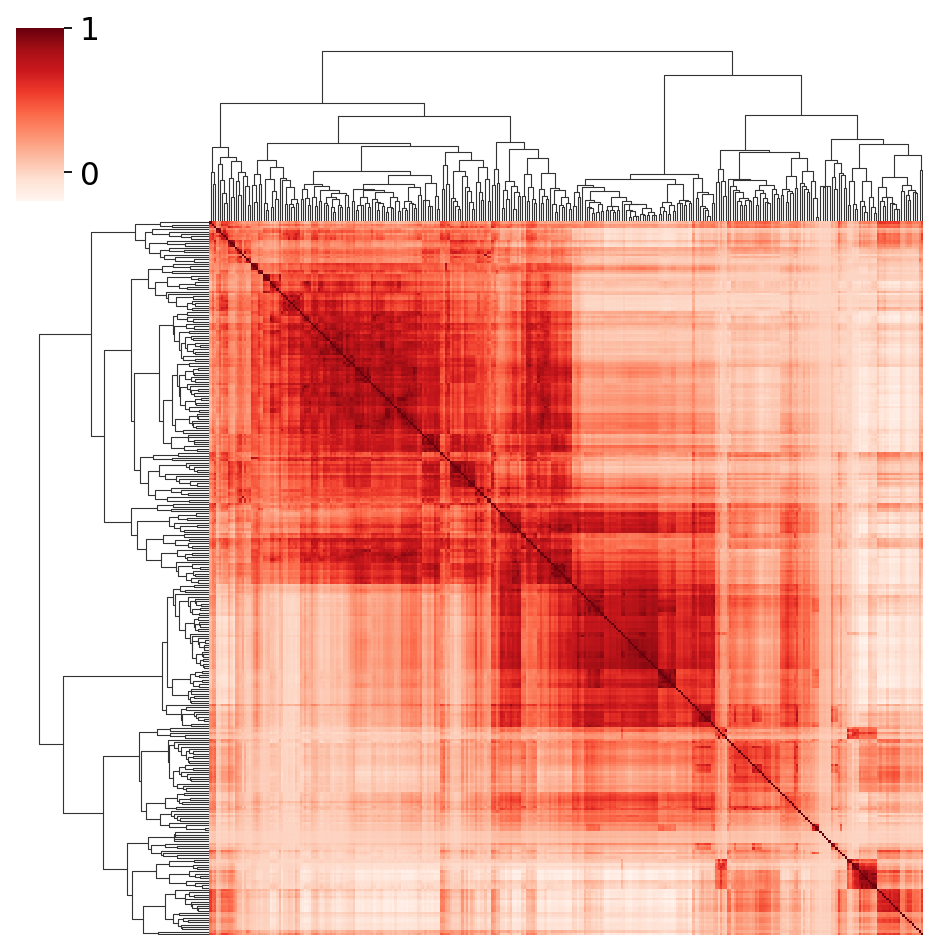

In [9]:
g = sns.clustermap(adata.to_df().T.corr(), cmap='Reds', figsize=[6, 6], xticklabels=False, yticklabels=False)

In [11]:
import pandas as pd

In [12]:
adata.obs_names = adata.obs['_index']
adata.obs['is.zero'] = pd.Categorical(adata.obs_names.str.contains('Zero'))

In [26]:
adata.obs['tf.name'] = list(data_sel['tf.name'])
adata.obs['accession'] = list(data_sel['accession'])

In [27]:
adata.obs['tf.name'].value_counts()

ZEROCYCLE    70
ELK1         38
ELK3         28
ETV4         28
ELF2         24
EGR1         23
ELF3         20
ELF4         16
FOXA1        16
ALX4         12
ETV5         12
ETS1         10
ALX1          8
ETV6          4
Name: tf.name, dtype: int64

In [28]:
for tf in set(adata.obs['tf.name']):
    print(tf, len(set(adata.obs[adata.obs['tf.name'] == tf]['accession'])))

ALX4 2
FOXA1 1
ZEROCYCLE 3
ETV5 2
EGR1 2
ELK3 2
ALX1 1
ELF3 2
ETV4 2
ETS1 1
ELF4 1
ETV6 1
ELF2 1
ELK1 2


In [29]:
adata[adata.obs['tf.name'] == 'ELK1',:].obs

_index batch cycle  \
_index                                                                   
ELK1_TAGCAG30NACT_AI_1              ELK1_TAGCAG30NACT_AI_1    AI         
ELK1_TAGCAG30NACT_AI_2              ELK1_TAGCAG30NACT_AI_2    AI         
ELK1_TAGCAG30NACT_AI_3              ELK1_TAGCAG30NACT_AI_3    AI         
ELK1_TAGCAG30NACT_AI_4              ELK1_TAGCAG30NACT_AI_4    AI         
ELK1_TAGCAG30NACT_AI_5              ELK1_TAGCAG30NACT_AI_5    AI         
ELK1_TAGCAG30NACT_AI_6              ELK1_TAGCAG30NACT_AI_6    AI         
ELK1_TCGGAA20NAGT_AG_1              ELK1_TCGGAA20NAGT_AG_1    AG         
ELK1_TCGGAA20NAGT_AG_2              ELK1_TCGGAA20NAGT_AG_2    AG         
ELK1_TCGGAA20NAGT_AG_3              ELK1_TCGGAA20NAGT_AG_3    AG         
ELK1_TCGGAA20NAGT_AG_4              ELK1_TCGGAA20NAGT_AG_4    AG         
ELK1_TGAGTG20NTGA_AG_1              ELK1_TGAGTG20NTGA_AG_1    AG         
ELK1_TGAGTG20NTGA_AG_2              ELK1_TGAGTG20NTGA_AG_2    AG         
ELK1_TGAGTG20NTGA_AG_3              ELK1_TGAGTG20NTGA_AG_3    AG         
ELK1_TGAGTG20NTGA_AG_4              ELK1_TGAGTG20NTGA_AG_4    AG         
ELK1_eDBD_1_KAN_TCGCAA40NTGT  ELK1_eDBD_1_KAN_TCGCAA40NTGT  eDBD         
ELK1_eDBD_1_KAN_TGAGCG40NTTG  ELK1_eDBD_1_KAN_TGAGCG40NTTG  eDBD         
ELK1_eDBD_1_KS_TGCCGA40NGTA    ELK1_eDBD_1_KS_TGCCGA40NGTA  eDBD         
ELK1_eDBD_1_KS_TGGTAC40NTCT    ELK1_eDBD_1_KS_TGGTAC40NTCT  eDBD         
ELK1_eDBD_2_KAN_TCGCAA40NTGT  ELK1_eDBD_2_KAN_TCGCAA40NTGT  eDBD         
ELK1_eDBD_2_KAN_TGAGCG40NTTG  ELK1_eDBD_2_KAN_TGAGCG40NTTG  eDBD         
ELK1_eDBD_2_KS_TGCCGA40NGTA    ELK1_eDBD_2_KS_TGCCGA40NGTA  eDBD         
ELK1_eDBD_2_KS_TGGTAC40NTCT    ELK1_eDBD_2_KS_TGGTAC40NTCT  eDBD         
ELK1_eDBD_3_KAN_TCGCAA40NTGT  ELK1_eDBD_3_KAN_TCGCAA40NTGT  eDBD         
ELK1_eDBD_3_KAN_TGAGCG40NTTG  ELK1_eDBD_3_KAN_TGAGCG40NTTG  eDBD         
ELK1_eDBD_3_KS_TGCCGA40NGTA    ELK1_eDBD_3_KS_TGCCGA40NGTA  eDBD         
ELK1_eDBD_3_KS_TGGTAC40NTCT    ELK1_eDBD_3_KS_TGGTAC40NTCT  eDBD         
ELK1_eDBD_4_KAN_TCGCAA40NTGT  ELK1_eDBD_4_KAN_TCGCAA40NTGT  eDBD         
ELK1_eDBD_4_KAN_TGAGCG40NTTG  ELK1_eDBD_4_KAN_TGAGCG40NTTG  eDBD         
ELK1_eDBD_4_KS_TGCCGA40NGTA    ELK1_eDBD_4_KS_TGCCGA40NGTA  eDBD         
ELK1_eDBD_4_KS_TGGTAC40NTCT    ELK1_eDBD_4_KS_TGGTAC40NTCT  eDBD         
ELK1_FL_1_KAE_TCAGTT40NTTG      ELK1_FL_1_KAE_TCAGTT40NTTG    FL         
ELK1_FL_1_KAE_TGTTAG40NACC      ELK1_FL_1_KAE_TGTTAG40NACC    FL         
ELK1_FL_2_KAE_TCAGTT40NTTG      ELK1_FL_2_KAE_TCAGTT40NTTG    FL         
ELK1_FL_2_KAE_TGTTAG40NACC      ELK1_FL_2_KAE_TGTTAG40NACC    FL         
ELK1_FL_3_KAE_TCAGTT40NTTG      ELK1_FL_3_KAE_TCAGTT40NTTG    FL         
ELK1_FL_3_KAE_TGTTAG40NACC      ELK1_FL_3_KAE_TGTTAG40NACC    FL         
ELK1_FL_4_KAE_TCAGTT40NTTG      ELK1_FL_4_KAE_TCAGTT40NTTG    FL         
ELK1_FL_4_KAE_TGTTAG40NACC      ELK1_FL_4_KAE_TGTTAG40NACC    FL         

                                                           filename  \
_index                                                                
ELK1_TAGCAG30NACT_AI_1              ELK1_TAGCAG30NACT_AI_1.fastq.gz   
ELK1_TAGCAG30NACT_AI_2              ELK1_TAGCAG30NACT_AI_2.fastq.gz   
ELK1_TAGCAG30NACT_AI_3              ELK1_TAGCAG30NACT_AI_3.fastq.gz   
ELK1_TAGCAG30NACT_AI_4              ELK1_TAGCAG30NACT_AI_4.fastq.gz   
ELK1_TAGCAG30NACT_AI_5              ELK1_TAGCAG30NACT_AI_5.fastq.gz   
ELK1_TAGCAG30NACT_AI_6              ELK1_TAGCAG30NACT_AI_6.fastq.gz   
ELK1_TCGGAA20NAGT_AG_1              ELK1_TCGGAA20NAGT_AG_1.fastq.gz   
ELK1_TCGGAA20NAGT_AG_2              ELK1_TCGGAA20NAGT_AG_2.fastq.gz   
ELK1_TCGGAA20NAGT_AG_3              ELK1_TCGGAA20NAGT_AG_3.fastq.gz   
ELK1_TCGGAA20NAGT_AG_4              ELK1_TCGGAA20NAGT_AG_4.fastq.gz   
ELK1_TGAGTG20NTGA_AG_1              ELK1_TGAGTG20NTGA_AG_1.fastq.gz   
ELK1_TGAGTG20NTGA_AG_2              ELK1_TGAGTG20NTGA_AG_2.fastq.gz   
ELK1_TGAGTG20NTGA_AG_3              ELK1_TGAGTG20NTGA_AG_3.fastq.gz   
ELK1_TGAGTG20NTGA_AG_4    

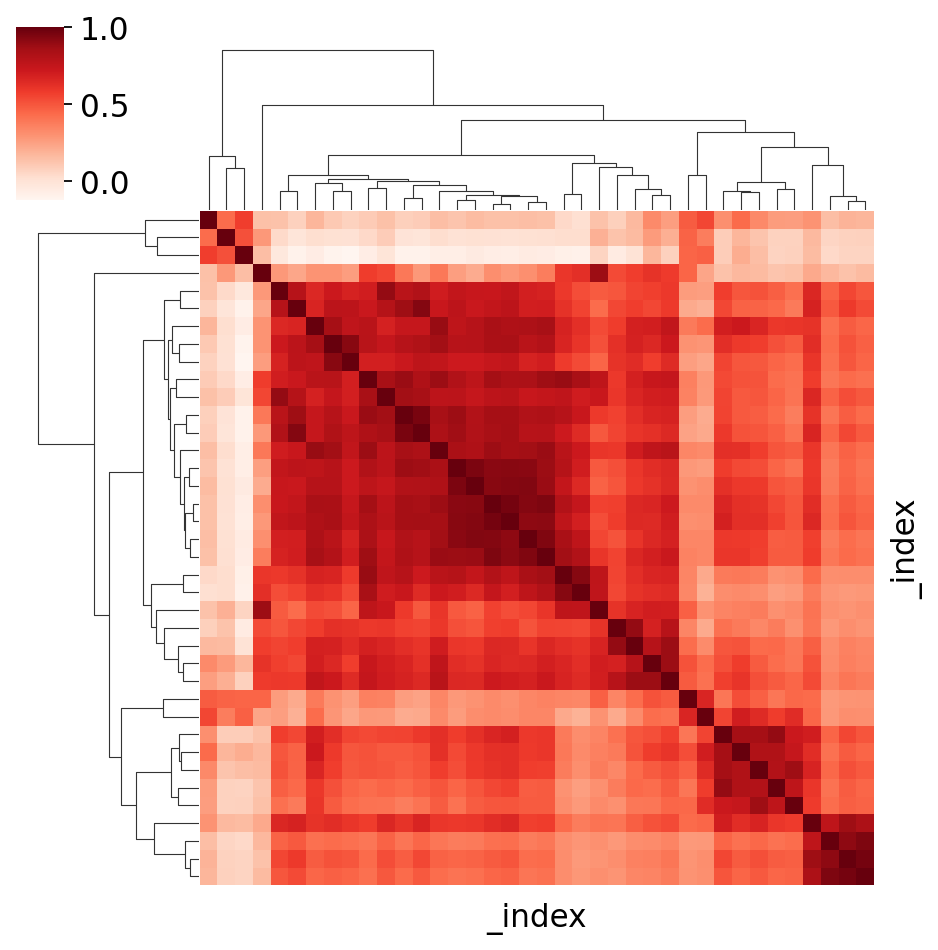

In [30]:
g = sns.clustermap(adata[adata.obs['tf.name'] == 'ELK1',:].to_df().T.corr(), cmap='Reds', figsize=[6, 6], xticklabels=False, yticklabels=False)

/home/rio/miniconda3/envs/multibind/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


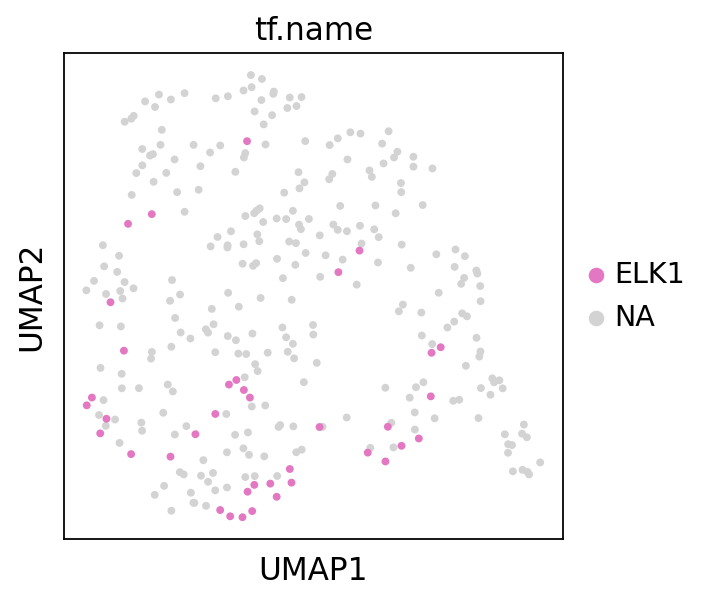

In [31]:
sc.pl.umap(adata, color=['tf.name'], groups=['ELK1'], s=50)

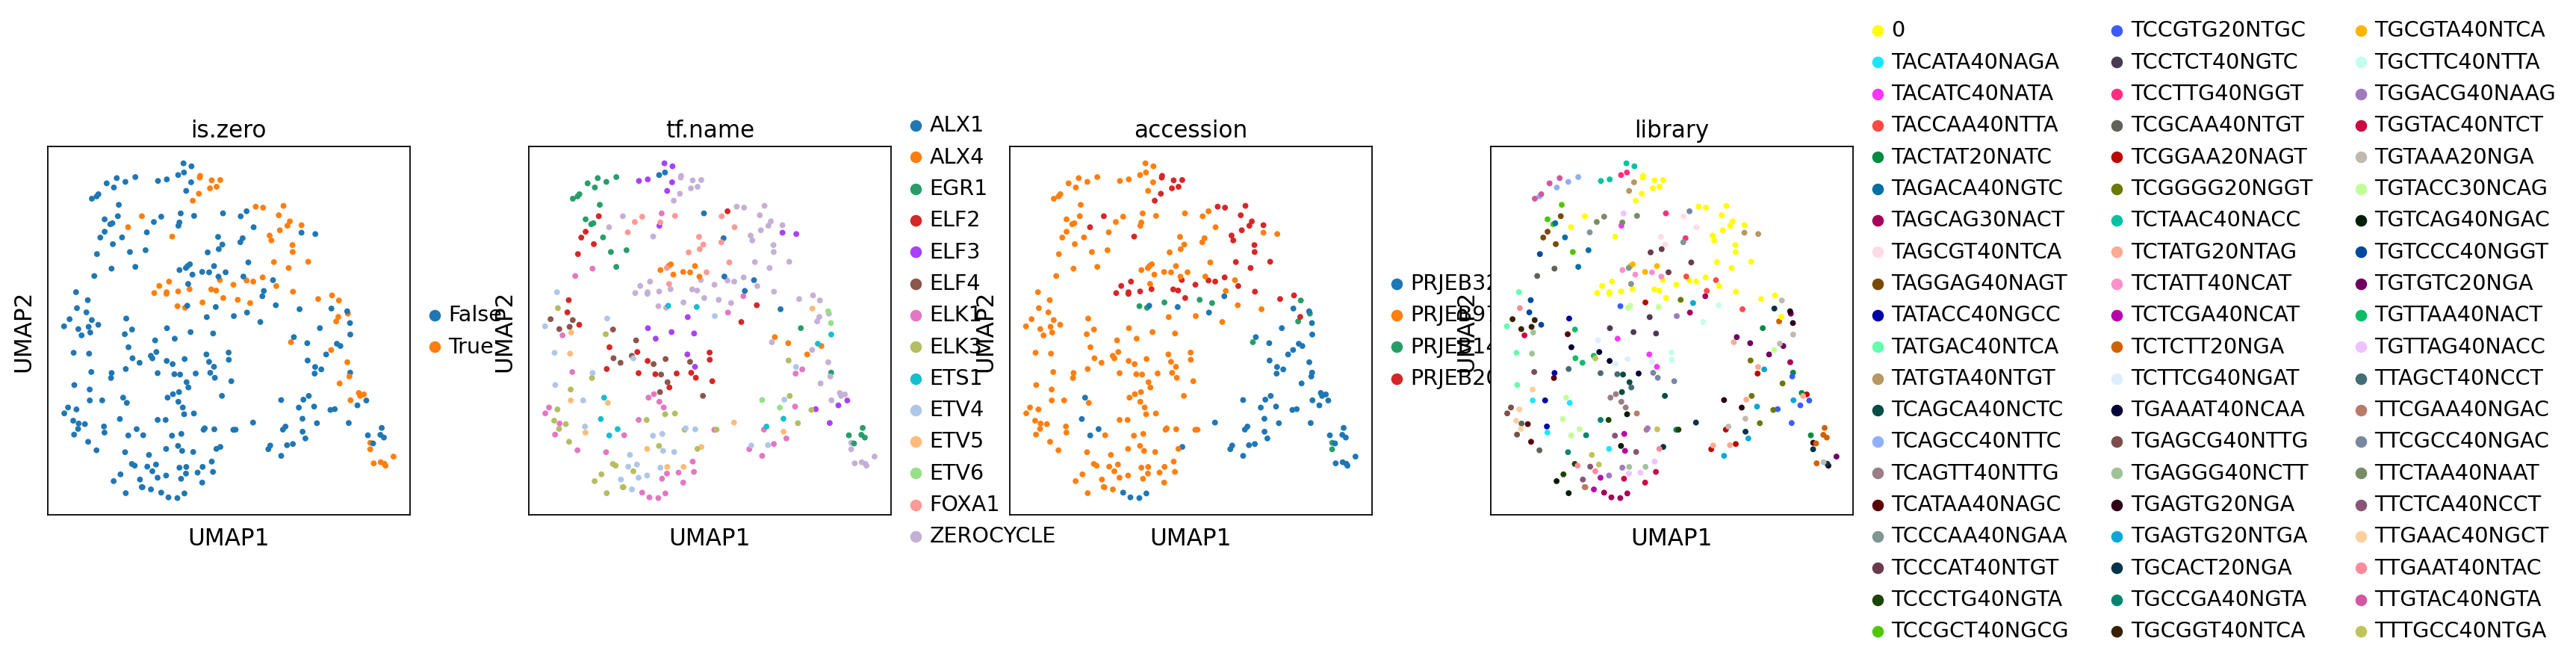

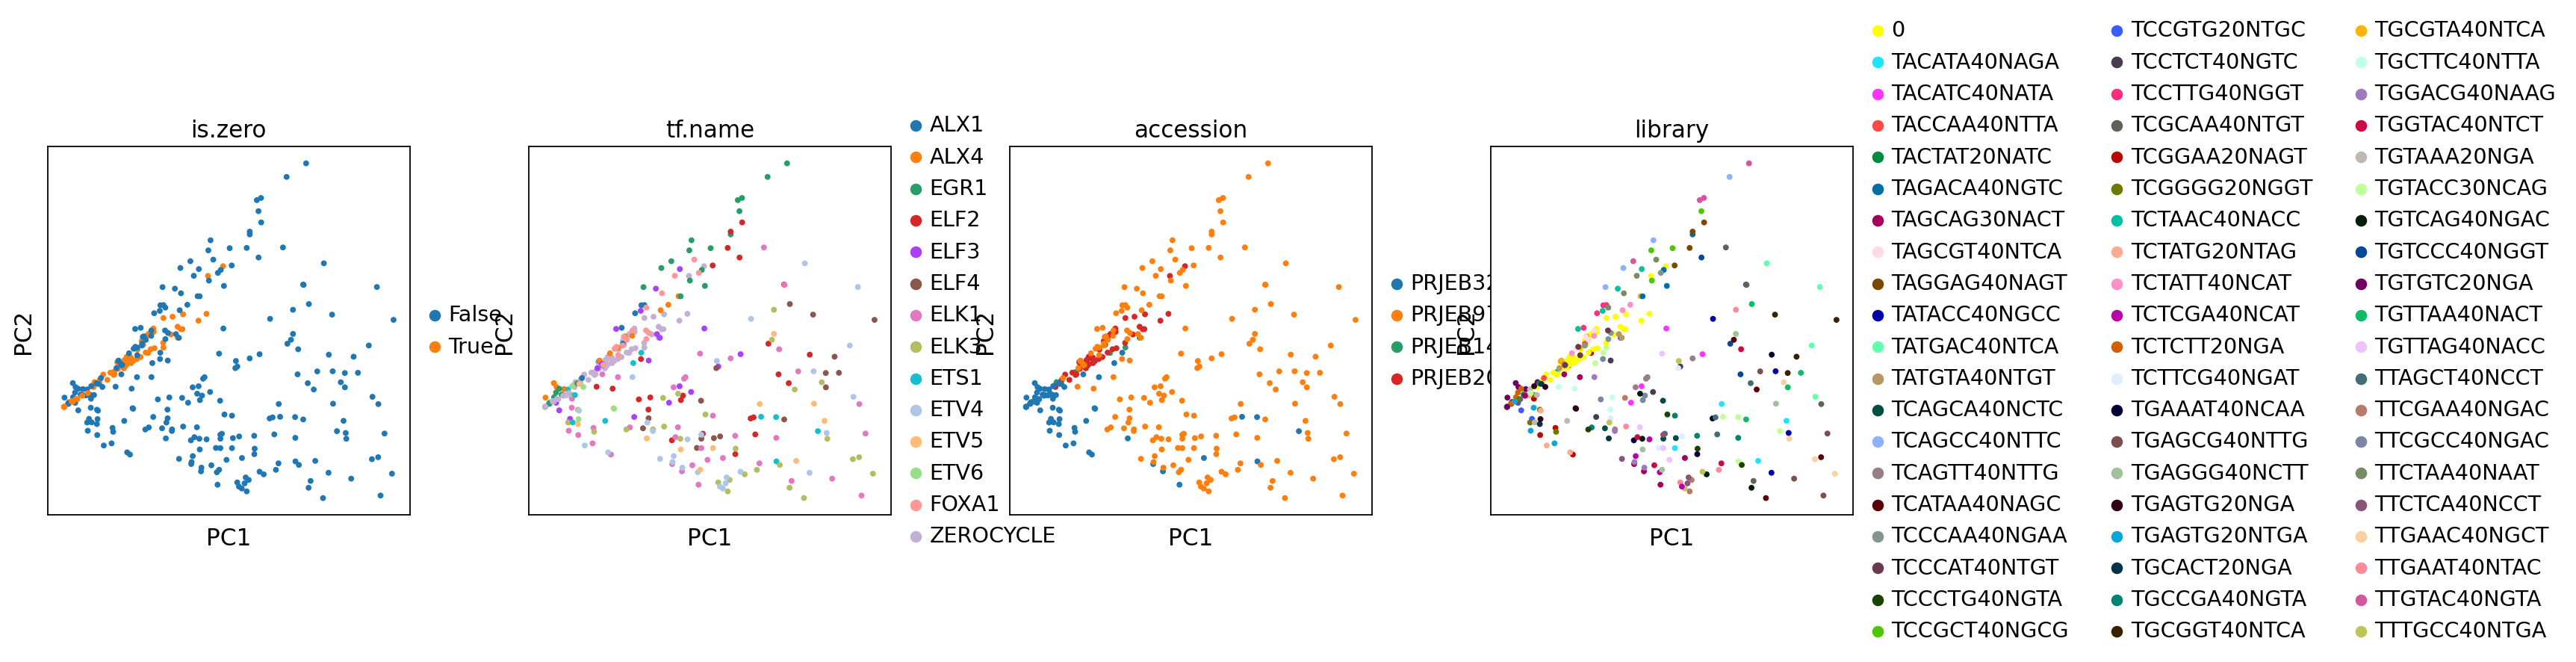

In [37]:
sc.pl.umap(adata, color=['is.zero', 'tf.name', 'accession', 'library'], s=50)
sc.pl.pca(adata, color=['is.zero', 'tf.name', 'accession', 'library'], s=50)


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.executable

In [ ]:
adata.to_df()

In [8]:
import numpy as np

In [10]:
import pandas

In [12]:
import multibind

In [15]:
!which ipython

/home/rio/miniconda3/bin/ipython


In [2]:
!which ipython

/home/rio/miniconda3/bin/ipython


In [2]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '/mnt/c/Users/ignacio.ibarra/Dropbox/annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/rio/miniconda3/envs/multibind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0


In [7]:
df = mb.bindome.datasets.ProBound.GR_mult_conc()
df = df.sort_values(1, ascending=False).reset_index(drop=True)

In [8]:
data = df.head(1000)

In [9]:
n_rounds = 1

In [10]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 9, 2

/tmp/ipykernel_13907/3315481419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['batch'] = 1
/tmp/ipykernel_13907/3315481419.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_count_data'] = 1


loading object (# entries) 1000


/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/multibind/multibind/tl/encoding.py:9: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "onehot_mononuc" failed type inference due to: non-precise type pyobject
During: typing of argument at /mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/multibind/multibind/tl/encoding.py (11)

File "../multibind/tl/encoding.py", line 11:
def onehot_mononuc(seq, label_encoder=LabelEncoder(), onehot_encoder=OneHotEncoder(sparse=False)):
    seq_arr = np.array(list(seq + 'ACGNT'))
    ^

  @jit
/home/rio/miniconda3/envs/multibind/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "onehot_mononuc" was compiled in object mode without forceobj=True.

File "../multibind/tl/encoding.py", line 10:
@jit
def onehot_mononuc(seq, label_encoder=LabelEncoder(), onehot_encoder=OneHotEncoder(sparse=False)):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/rio/min

next w 14
kernel to optimize 0
setting kernel at 0 to 1
setting kernel at 1 to 0
mono grad 1 None
di grad 1 None
Epoch:  1, Loss: nan
Epoch: 11, Loss: nan
before shift optim.


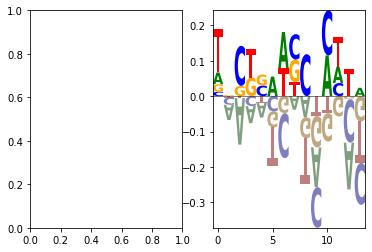

after shift optimz model


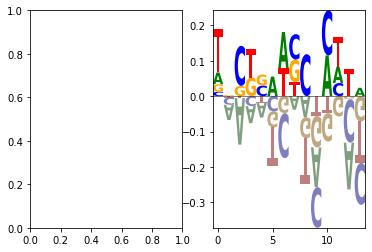


kernel to optimize 1
setting kernel at 0 to 0
setting kernel at 1 to 1
mono grad 1 None
di grad 1 None
Epoch:  1, Loss: nan
Epoch: 11, Loss: nan
before shift optim.


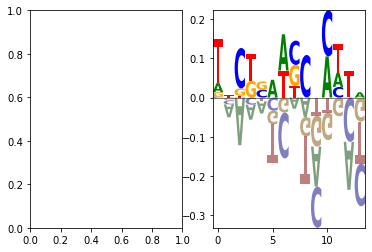

optimize_motif_shift (once)...mono grad 1 None
di grad 1 None
mono grad 1 None
di grad 1 None
nan nan nan
after shift optimz model


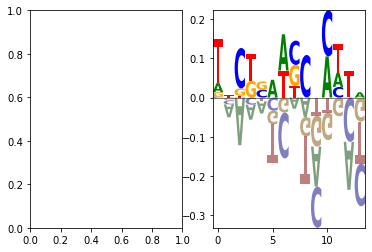


next w 16
kernel to optimize 0
setting kernel at 0 to 1
setting kernel at 1 to 0
mono grad 1 None
di grad 1 None
Epoch:  1, Loss: nan
Epoch: 11, Loss: nan
before shift optim.


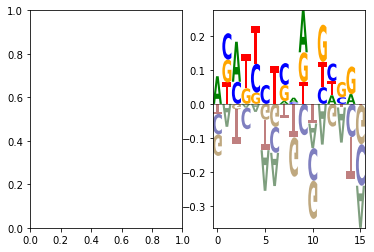

after shift optimz model


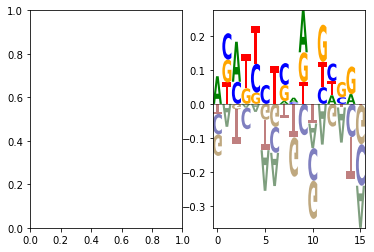


kernel to optimize 1
setting kernel at 0 to 0
setting kernel at 1 to 1
mono grad 1 None
di grad 1 None
Epoch:  1, Loss: nan
Epoch: 11, Loss: nan
before shift optim.


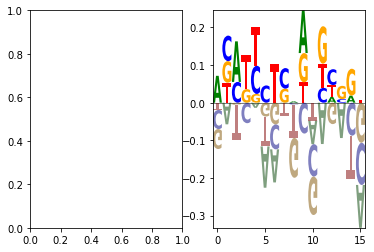

optimize_motif_shift (once)...mono grad 1 None
di grad 1 None
mono grad 1 None
di grad 1 None
nan nan nan
after shift optimz model


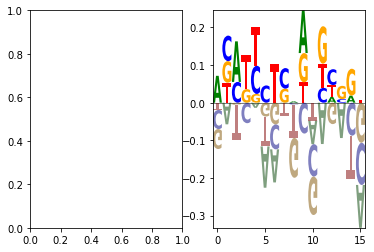

In [11]:
# assign batch and data type

data['batch'] = 1
data['is_count_data'] = 1

print('loading object (# entries)', data.shape[0])
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds, single_encoding_step=True)
train = tdata.DataLoader(dataset=dataset, batch_size=25000, shuffle=True)

model_by_k_next, res_next = mb.tl.train_iterative(train, device, min_w=16, max_w=18, n_rounds=n_rounds, n_kernels=2)                
res = []
model_by_k = {}


In [101]:
adata.obs['is.zero'] = adata.obs_names.str.contains('Zero').astype('categorical')

TypeError: data type 'categorical' not understood

In [93]:
adata

AnnData object with n_obs × n_vars = 331 × 8372
    obs: 'is.zero'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

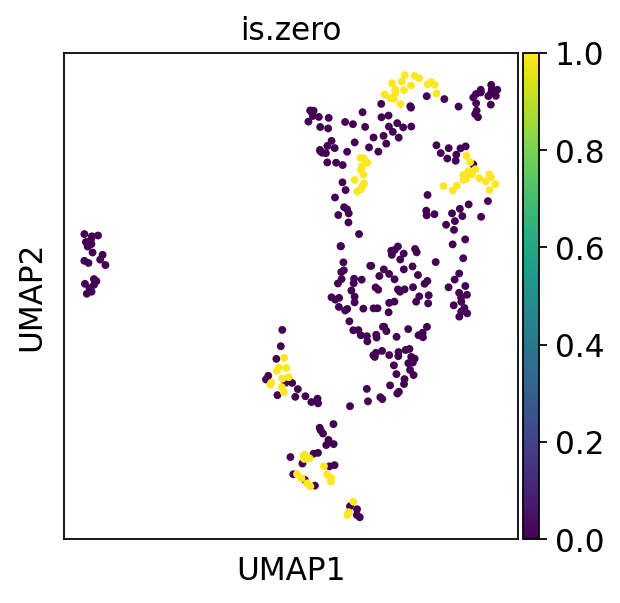

In [96]:
sc.pl.umap(adata, color='is.zero', s=50)

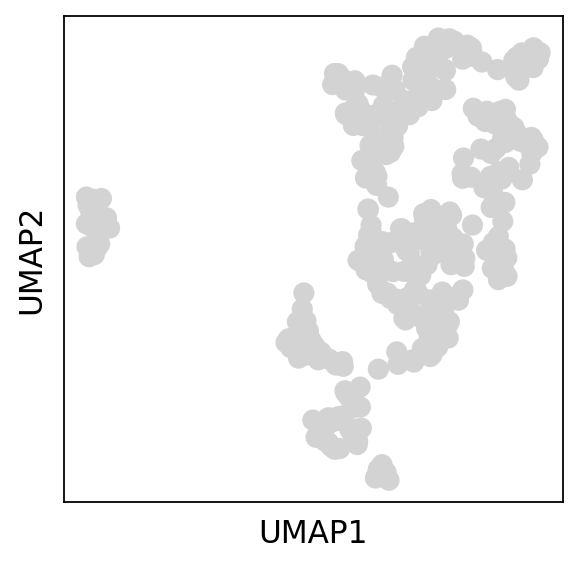

In [79]:
sc.pl.umap(adata)